# Tutorial for solving Bloch eigenvalue problem wiht FenicsX

In [1]:
# ################################################## #
# Genearal imports                                   #
# ################################################## #
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# ################################################## #
# Imports for plotting                               #
# ################################################## #
import matplotlib.pyplot as plt
from dolfinx.io import gmshio
import pyvista
pyvista.start_xvfb()

# ################################################## #
# Imports for the meshing                            #
# ################################################## #
import gmsh
from MeshFunctions      import get_mesh_SquareSpline,get_mesh_SquareMultiSpline
from dolfinx.plot       import create_vtk_mesh
from dolfinx.io         import XDMFFile
from dolfinx.io.gmshio  import model_to_mesh

# ################################################## #
# Imports for finite element modeling                #
# ################################################## #
from mpi4py import MPI
import dolfinx_mpc
import dolfinx
from dolfinx.fem    import Function, FunctionSpace, VectorFunctionSpace
from dolfinx.mesh   import create_unit_square 
from dolfinx.mesh   import create_rectangle
from dolfinx.fem    import form
from dolfinx.fem.petsc import assemble_matrix
from dolfinx    import plot
from dolfinx.io import gmshio
from mpi4py     import MPI
from dolfinx    import fem
from ufl        import TrialFunction, TestFunction, grad, dx, dot, nabla_div, Identity, nabla_grad, inner, sym
from petsc4py.PETSc import ScalarType
from slepc4py   import SLEPc
from petsc4py   import PETSc
from typing     import List
import scipy.sparse
from scipy.sparse.linalg import eigsh
from scipy import sparse

Info    : Clearing all models and views...
Info    : Done clearing all models and views
[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]
 --------- ERROR HERE --------------
Info    : Error in transformation from curve 2 (27-25) to 4 (28-27) (minimal transformed node distances 0 0.141421, tolerance 1.41422e-09)
Info    : Error in transformation from curve 3 (26-28) to 1 (25-26) (minimal transformed node distances 0.223607 0.1, tolerance 1.41422e-09)
 --------- ERROR HERE --------------
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (BSpline)
Info    : Done meshing 1D (Wall 0.122413s, CPU 0.095673s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.113158s, CPU 0.093058s)
Info    : 2820 nodes 5625 elements
to here
Generated Mesh in 0.588 Seconds



No module named 'trame'

Falling back to a static output.
  warnings.warn(



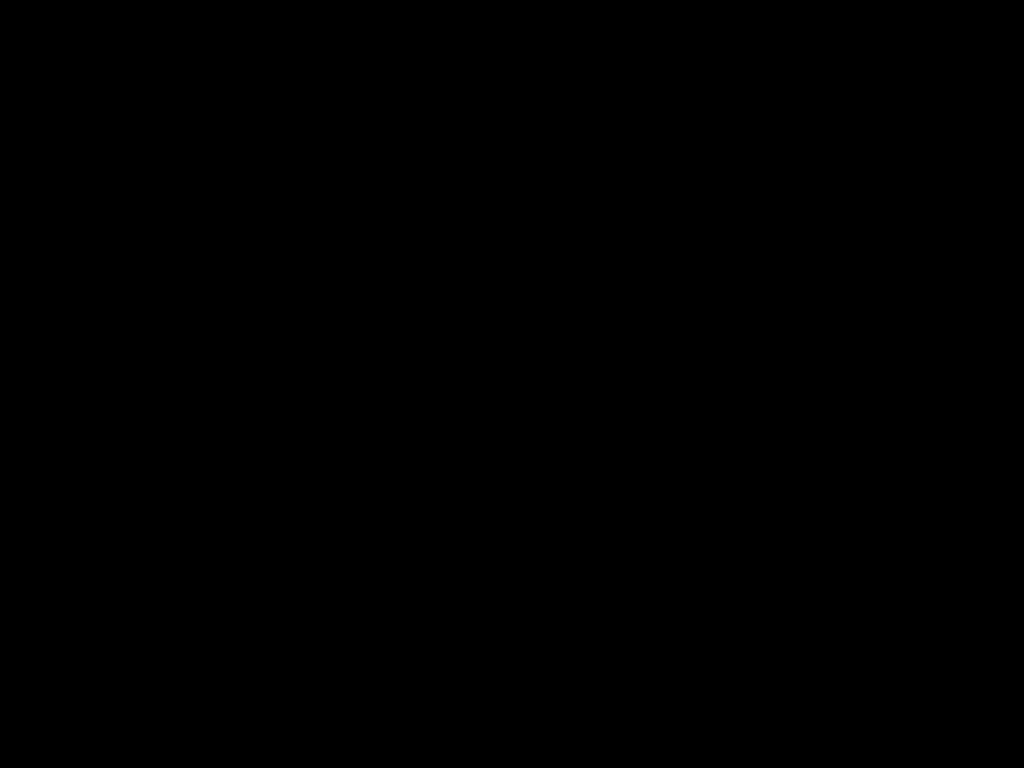

In [2]:
start = time.time()
######################################################################
#                      Domain  Inputs                                #
######################################################################
#   a_len               Charecterstic unit cell length (primitive basis)
#   r                   vector of points to fit spline to
#   Nquads              Number of quadrants to repeat spline through (radially)
#   offset              Offset angle for inclusion geometry
#   iscut               Choose if inclusion is void or an added domain
######################################################################
a_len = .1
# r         =     a_len*np.array([1.1,.1,0,.1, 1.65,.1,0,.1])*.75/2
# r           =   a_len*np.array([1,.5,.7])*.95
# r           =   a_len*np.array([1,.5,.7])*.95
r           = np.array([1,.2,.4])*a_len*.95
r           = a_len*np.random.rand(4,1)*1.1; r= r.T; r = r[0];
offset      = np.pi/8

Nquads      = 5
# Nominal paramters (physcial)
c           = [1500,5100]
rho         = [1e3,7e3]
c           = [30]
rho         = [1.2]
######################################################################
#                      Mesh Inputs                                   #
######################################################################
#   refinement_level    Choose how much denser mesh gets around refinement field
#   refinement_dist     Maximum distance of refinement field from refined edges
#   isrefined           Choose whether or not to refine mesh around internal edges
#   meshalg             Meshing algorithm for gmsh to use
######################################################################
da                  =   a_len/30
meshalg             =   7
refinement_level    =   3
refinement_dist     =   a_len/10

######################################################################
#                        Solver inputs                               #
######################################################################
# npi       Number of points to loop through i-th cut of IBZ
# nvec      Number of eigenvectrs to solve for in each step
# fspace    Function space to use
######################################################################
np1  = 20
np2  = 20
np3  = 20
nvec = 20


######################################################################
#                  Generate a mesh with one inlsuion                 #
######################################################################
meshalg                 = 6
gmsh.model, xpt, ypt    = get_mesh_SquareSpline(a_len ,da,r,Nquads,offset,meshalg,
                                                refinement_level,refinement_dist,
                                                isrefined = True, cut = True)


#################################################################
#            Import to dolfinx and save as xdmf                 #
#################################################################
mesh_comm = MPI.COMM_WORLD
model_rank = 0
mesh, ct, _ = model_to_mesh(gmsh.model, mesh_comm, model_rank, gdim=2)
with XDMFFile(MPI.COMM_WORLD, "mt.xdmf", "w") as xdmf:
    xdmf.write_mesh(mesh)
    xdmf.write_meshtags(ct)
t1 =  round(time.time()-start,3)
print('Generated Mesh in ' + str(t1)  + ' Seconds')      
         
#################################################################
#              Plot the mesh                                    #
#################################################################
V = FunctionSpace(mesh,('CG',1))
v = Function(V)
plotter = pyvista.Plotter()
grid = pyvista.UnstructuredGrid(*create_vtk_mesh(mesh, mesh.topology.dim))
num_local_cells = mesh.topology.index_map(mesh.topology.dim).size_local
grid.cell_data["Marker"] = 1-ct.values[ct.indices<num_local_cells]
grid.set_active_scalars("Marker")
actor = plotter.add_mesh(grid, show_edges=True, line_width= 1, edge_color= 'w')
# actor = plotter.add_mesh(grid, style="wireframe", color= 'w', line_width=3)
plotter.set_background('black', top='black')
plotter.view_xy()
plotter.screenshot('Mesh.jpeg',window_size=[2000,1400])
plotter.add_title('CELLS:'+str(ct.values.shape[0])+ '  | NODES:'+str(v.vector[:].shape[0]))
plotter.show()

#################################################################
#       HELPERS FOR MTRICE                        #
#################################################################
def petsc_to_numpy(A):
    sz = A.getSize()
    A_ = np.zeros(sz, dtype=PETSc.ScalarType)
    for i in range(sz[0]):
        row = A.getRow(i)
        A_[i, row[0]] = row[1]
    return A_

def complex_formatter(x):
    return "{0:-10.3e}{1:+10.3e}j".format(np.real(x), np.imag(x))

def print_matrix(A):
    print(
        np.array2string(
            A,
            max_line_width=np.inf,
            separator=" ",
            formatter={"complexfloat": complex_formatter}
        )
    )
    

#################################################################
#       Function for solving eigenproblem                       #
#################################################################
# Function for computing eigenvalues
def get_EPS(A, B, nvec):
    EPS = SLEPc.EPS()
    EPS.create(comm=MPI.COMM_WORLD)
    EPS.setOperators(A, B)
    EPS.setProblemType(SLEPc.EPS.ProblemType.GNHEP)
    # set the number of eigenvalues requested
    EPS.setDimensions(nev=nvec)
    # Set solver
    EPS.setType(SLEPc.EPS.Type.KRYLOVSCHUR)
    # set eigenvalues of interest
    EPS.setWhichEigenpairs(SLEPc.EPS.Which.TARGET_MAGNITUDE)
    EPS.setTarget(0)  # sorting
    # set tolerance and max iterations
    EPS.setTolerances(tol=1e-5, max_it=12)
    # Set up shift-and-invert
    # Only work if 'whichEigenpairs' is 'TARGET_XX'
    ST = EPS.getST()
    ST.setType(SLEPc.ST.Type.SINVERT)
    ST.setShift(10)
    EPS.setST(ST)
    # parse command line options
    EPS.setFromOptions()
    return EPS


#################################################################
#       Function for solving eigenproblem with scipy            #
#################################################################
def scipysolve(A,B, nval):
    K = petsc_to_numpy(A)
    M = petsc_to_numpy(B)
    K = sparse.csr_array(K)
    M = sparse.csr_array(M)
    eval, evec = eigsh(K, k = nval, M=M, sigma = 1.0)
    return eval, evec

#################################################################
#   Function for solving complex eigenproblem with scipy        #
#################################################################
def scipysolve_complex(A_re, A_im, B, nval):
    A_re_np = petsc_to_numpy(A_re)
    A_im_np = petsc_to_numpy(A_im)
    Kcomp    = A_re_np+1j*A_im_np
    eval, evec = eigsh(Kcomp, k = 24, M=Mcomp, sigma = 1.0)
    return eval, evec

In [3]:
#################################################################
#       Function for multi point constraint                     #
#################################################################
def dirichlet_and_periodic_bcs(domain, functionspace, boundary_condition: List[str] = ["dirichlet", "periodic"], dbc_value = 0):
    """
    Function to set either dirichlet or periodic boundary conditions
    ----------
    boundary_condition
        First item describes b.c. on {x=0} and {x=1}
        Second item describes b.c. on {y=0} and {y=1}
    """
    
    fdim = domain.topology.dim - 1
    bcs             = []
    pbc_directions  = []
    pbc_slave_tags  = []
    pbc_is_slave    = []
    pbc_is_master   = []
    pbc_meshtags    = []
    pbc_slave_to_master_maps = []

    def generate_pbc_slave_to_master_map(i):
        def pbc_slave_to_master_map(x):
            out_x = x.copy() # was ist x.copy()?
            out_x[i] = x[i] - domain.geometry.x.max()
            return out_x
        return pbc_slave_to_master_map

    def generate_pbc_is_slave(i):
        return lambda x: np.isclose(x[i], domain.geometry.x.max())

    def generate_pbc_is_master(i):
        return lambda x: np.isclose(x[i], domain.geometry.x.min())

    # Parse boundary conditions
    for i, bc_type in enumerate(boundary_condition):
        
        if bc_type == "dirichlet":
            u_bc = fem.Function(functionspace)
            u_bc.x.array[:] = dbc_value # value of dirichlet bc needs to be passed into this function!

            def dirichletboundary(x):
                return np.logical_or(np.isclose(x[i], domain.geometry.x.min()), np.isclose(x[i], domain.geometry.x.max()))
            facets = locate_entities_boundary(domain, fdim, dirichletboundary)
            topological_dofs = fem.locate_dofs_topological(functionspace, fdim, facets)
            bcs.append(fem.dirichletbc(u_bc, topological_dofs))
        
        elif bc_type == "periodic":
            pbc_directions.append(i)
            pbc_slave_tags.append(i + 2)
            pbc_is_slave.append(generate_pbc_is_slave(i))
            pbc_is_master.append(generate_pbc_is_master(i))
            pbc_slave_to_master_maps.append(generate_pbc_slave_to_master_map(i))

            facets = dolfinx.mesh.locate_entities_boundary(domain, fdim, pbc_is_slave[-1])
            arg_sort = np.argsort(facets)
            pbc_meshtags.append(dolfinx.mesh.meshtags(domain,
                                          fdim,
                                          facets[arg_sort],
                                          np.full(len(facets), pbc_slave_tags[-1], dtype=np.int32)))

    # Create MultiPointConstraint object
    mpc =dolfinx_mpc.MultiPointConstraint(functionspace)
    
    N_pbc = len(pbc_directions)
    for i in range(N_pbc):
        if N_pbc > 1:
            def pbc_slave_to_master_map(x):
                out_x = pbc_slave_to_master_maps[i](x)
                idx = pbc_is_slave[(i + 1) % N_pbc](x)
                out_x[pbc_directions[i]][idx] = np.nan
                return out_x
        else:
            pbc_slave_to_master_map = pbc_slave_to_master_maps[i]

        # mpc.create_periodic_constraint_topological(functionspace, pbc_meshtags[i],
        #                                             pbc_slave_tags[i],
        #                                             pbc_slave_to_master_map,
        #                                             bcs)
        
        # print('MPC DEFINED (a)')
        if functionspace.num_sub_spaces == 0:
            mpc.create_periodic_constraint_topological(functionspace, pbc_meshtags[i],
                                            pbc_slave_tags[i],
                                            pbc_slave_to_master_map,
                                            bcs)
            print('MPC DEFINED (tag a)')
        else:
            for i in range(functionspace.num_sub_spaces):
                mpc.create_periodic_constraint_topological(functionspace.sub(i), pbc_meshtags[i],
                                                pbc_slave_tags[i],
                                                pbc_slave_to_master_map,
                                                bcs)
                print('SUBSPACE MPC DEFINED (tag b)')
                
    if len(pbc_directions) > 1:
        # Map intersection(slaves_x, slaves_y) to intersection(masters_x, masters_y),
        # i.e. map the slave dof at (1, 1) to the master dof at (0, 0)
        def pbc_slave_to_master_map(x):
            out_x = x.copy()
            out_x[0] = x[0] - domain.geometry.x.max()
            out_x[1] = x[1] - domain.geometry.x.max()
            idx = np.logical_and(pbc_is_slave[0](x), pbc_is_slave[1](x))
            out_x[0][~idx] = np.nan
            out_x[1][~idx] = np.nan
            return out_x
        # mpc.create_periodic_constraint_topological(functionspace, pbc_meshtags[1],
        #                                             pbc_slave_tags[1],
        #                                             pbc_slave_to_master_map,
        #                                             bcs)
        # print('MPC DEFINED (c)')
        
        if functionspace.num_sub_spaces == 0:
            mpc.create_periodic_constraint_topological(functionspace, pbc_meshtags[1],
                                                pbc_slave_tags[1],
                                                pbc_slave_to_master_map,
                                                bcs)
            print('MPC DEFINED (tag c)')
            
        else:
            for i in range(functionspace.num_sub_spaces):
                mpc.create_periodic_constraint_topological(functionspace.sub(i), pbc_meshtags[1],
                                                    pbc_slave_tags[1],
                                                    pbc_slave_to_master_map,
                                                    bcs)
                print('SUBSPACE MPC DEFINED (tag d)')
            
    mpc.finalize()
    return mpc, bcs

In [4]:
if len(rho) > 1:
    # E.g., if more than one physical group assigned.
    # Assign material propoerties to each physical group.
    Q = FunctionSpace(mesh, ("DG", 0))
    E = Function(Q)
    Rho = Function(Q)    
    material_tags   = np.unique(ct.values)
    disk1_cells     = ct.find(1)
    disk2_cells     = ct.find(2)
    Rho.x.array[disk1_cells]    = np.full_like(disk1_cells, rho[0], dtype=ScalarType)
    Rho.x.array[disk2_cells]    = np.full_like(disk2_cells, rho[1], dtype=ScalarType)
    E.x.array[disk1_cells]      = np.full_like(disk1_cells,  c[0], dtype=ScalarType)
    E.x.array[disk2_cells]      = np.full_like(disk2_cells,  c[1], dtype=ScalarType)

else:
    Rho = rho[0]
    E   = c[0]

We set the weak form for mass first, since this does not depend on wave vector and therefor anly needs to be asembled once.

In [5]:
#################################################################
#     Assign function space and constarint to mesh              #
#################################################################
V = FunctionSpace(mesh,('CG',1))
mpc, bcs = dirichlet_and_periodic_bcs(mesh, V, ["periodic", "periodic"]) 
u_tr    = TrialFunction(V)
u_test  = TestFunction(V) 
m_form = Rho*dot(u_tr, u_test)*dx


#################################################################
#        Define Mass Mat  outside of  IBZ loop                  #
#################################################################
m = form(m_form)
diagval_B = 1e-2
B = dolfinx_mpc.assemble_matrix(m, mpc, bcs=bcs, diagval=diagval_B)
M_np = petsc_to_numpy(B)
B.assemble()
assert isinstance(B, PETSc.Mat)
ai, aj, av = B.getValuesCSR()
Mcomp = scipy.sparse.csr_matrix((av+0j*av, aj, ai))

MPC DEFINED (tag a)
MPC DEFINED (tag a)
MPC DEFINED (tag c)


Now write a function to assemble the stiffness matrix and solve the sysetm for a given set of wavector coordinates.

We solve the eigenvalue problem using scipy sparse solver (if you have the complex build of fenicsx, you could use PETSc instead)

In [13]:
def solvesys(kx,ky,E,Mcomp,mpc,bcs,nvec, mesh, u_tr, u_test):
    '''
    ===================================
        Solving the FEM proble
    ===================================
    '''
    K = fem.Constant(mesh, PETSc.ScalarType((kx,ky)))
    a_form_re = E**2*(inner(grad(u_tr), grad(u_test)) + u_tr*u_test*(kx**2+ky**2))*dx
    a_form_im = E**2*(u_tr*inner(grad(u_test),K) - u_test*inner(grad(u_tr),K))*dx
    a_re = form(a_form_re)
    a_im = form(a_form_im)
    diagval_A = 1e8
    A_re = dolfinx_mpc.assemble_matrix(a_re, mpc, bcs=bcs, diagval=diagval_A)
    A_im = dolfinx_mpc.assemble_matrix(a_im, mpc, bcs=bcs, diagval=diagval_A)
    ############################################
    # efficient conversion to scipy for 
    # solving the complex problem (recommended)
    ############################################
    A_re.assemble()
    assert isinstance(A_re, PETSc.Mat)
    ai, aj, av = A_re.getValuesCSR()
    A_im.assemble()
    assert isinstance(A_im, PETSc.Mat)
    _,_, av_im = A_im.getValuesCSR()
    ############################################
    # Gettning solutinons
    ############################################
    Kcomp = scipy.sparse.csr_matrix((av+1j*av_im, aj, ai))
    eval, evec= eigsh(Kcomp, k = nvec, M=Mcomp, sigma = 1.0)
    return eval, evec 


Test a couple of coordinates out

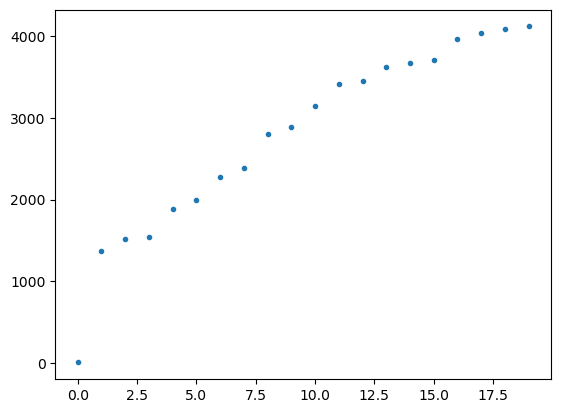

In [14]:
ky = 0
kx = .2

K = fem.Constant(mesh, PETSc.ScalarType((kx,ky)))
eval, evec = solvesys(kx,ky,E,Mcomp,mpc,bcs,nvec, mesh, u_tr, u_test)
eval[np.isclose(eval,0)] == 0
eigfrq_sp_cmp = np.real(eval)**.5
eigfrq_sp_cmp = np.sort(eigfrq_sp_cmp )
evals_disp.append(eigfrq_sp_cmp )
evec_all.append(evec)

plt.plot(eigfrq_sp_cmp,'.')

Now loop through the IBZ to compute a band structure

In [15]:
######################################################################################
#       ---             LOOPING THROUGH THE IBZ              ---                     #
######################################################################################
ky = 0
tsolve = []
evals_disp =[]
maxk = np.pi/a_len
start=time.time()
evec_all = []
print('Computing Band Structure .... ')
#################################################################
#            Computing K to M                                   #
#################################################################
print('Computing Gamma to  X')
for kx in np.linspace(0.01,maxk,np1):
    K = fem.Constant(mesh, PETSc.ScalarType((kx,ky)))
    eval, evec = solvesys(kx,ky,E,Mcomp,mpc,bcs,nvec, mesh, u_tr, u_test)
    eval[np.isclose(eval,0)] == 0
    eigfrq_sp_cmp = np.real(eval)**.5
    eigfrq_sp_cmp = np.sort(eigfrq_sp_cmp )
    evals_disp.append(eigfrq_sp_cmp )
    evec_all.append(evec)
    
#################################################################
#            Computing K to M                                   #
#################################################################
print('Computing X to  M')
kx = maxk
for ky in np.linspace(0.01,maxk,np2):
    K = fem.Constant(mesh, PETSc.ScalarType((kx,ky)))
    # start=time.time()
    eval, evec = solvesys(kx,ky,E,Mcomp,mpc,bcs,nvec, mesh, u_tr, u_test)
    eval[np.isclose(eval,0)] == 0
    eigfrq_sp_cmp = np.real(eval)**.5
    eigfrq_sp_cmp = np.sort(eigfrq_sp_cmp )
    evals_disp.append(eigfrq_sp_cmp )
    evec_all.append(evec)

#################################################################
#            Computing M To Gamma                               #
#################################################################
print('Computing M to Gamma')
for kx in np.linspace(maxk,0.01,np3):
    ky = kx
    K = fem.Constant(mesh, PETSc.ScalarType((kx,ky)))
    # start=time.time()
    eval, evec = solvesys(kx,ky,E,Mcomp,mpc,bcs,nvec, mesh, u_tr, u_test)
    eval[np.isclose(eval,0)] == 0
    eigfrq_sp_cmp = np.real(eval)**.5
    eigfrq_sp_cmp = np.sort(eigfrq_sp_cmp)
    evals_disp.append(eigfrq_sp_cmp )
    evec_all.append(evec)
    # print(np.round(time.time()-start,3))
# print(np.round(time.time()-start,3))

Computing Band Structure .... 
Computing Gamma to  X
Computing X to  M
Computing M to Gamma


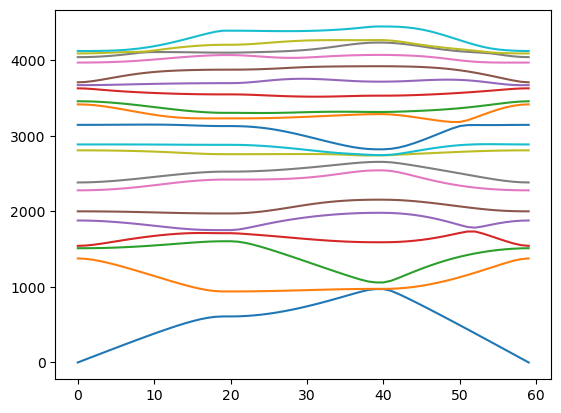

In [18]:
plt.plot(np.array(evals_disp))

Visualize the eigenvectors

  mycmap = plt.cm.get_cmap('seismic', 10)


No module named 'trame'

Falling back to a static output.
  warnings.warn(

D3D12: Removing Device.


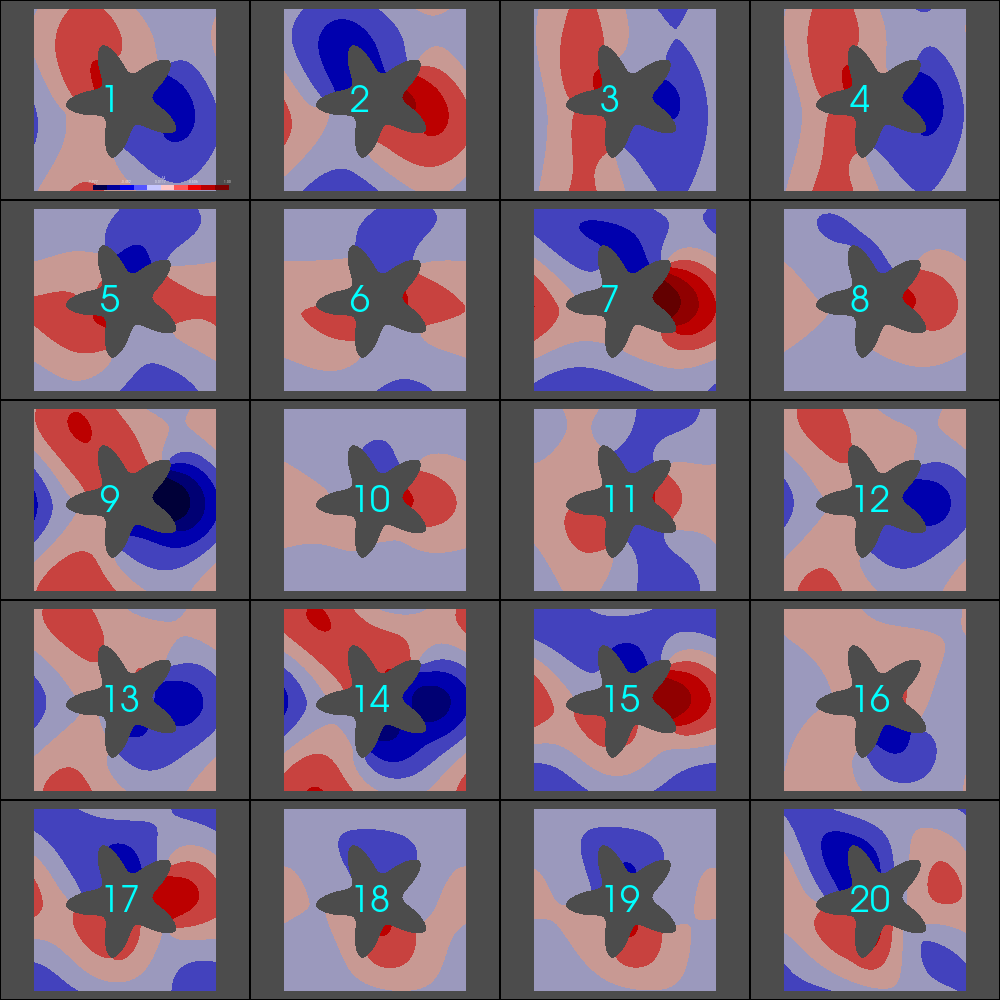

In [20]:
testload = np.array(evec_all) #np.load('data//testFile.npy')
plotter = pyvista.Plotter(shape=(5,4) , window_size=(1000,1000))
###########################################################
# Post-processing the eigenvectors
###########################################################
euse = 0
for i in range(5):
    for j in range(4):
        plotter.subplot(i,j)
        et = testload[euse,:,3]; euse += 1
        vr = Function(V)
        vi = Function(V)
        vr.vector[:] = np.real(et)
        vi.vector[:] = np.imag(et)
        vr.x.scatter_forward()
        mpc.backsubstitution(vr.vector)
        vi.x.scatter_forward()
        mpc.backsubstitution(vi.vector)


        ###########################################################
        # Plotting eigenvectors with pyvista
        ###########################################################
        # mycmap = plt.cm.get_cmap('coolwarm', 10)
        mycmap = plt.cm.get_cmap('seismic', 10)
        u = Function(V)
        cells, types, x = plot.create_vtk_mesh(V)
        grid = pyvista.UnstructuredGrid(cells, types, x)
        grid.point_data["u"] = u.x.array
        u.vector.setArray(vr.vector[:]/np.max(vr.vector[:])*np.sign(vr.vector[10]))
        edges = grid.extract_all_edges()
        warped = grid.warp_by_scalar("u", factor=0)
        plotter.add_mesh(warped, show_edges=False, show_scalar_bar=True, scalars="u",cmap=mycmap)
        # plotter.add_mesh(grid, style = 'wireframe', line_width = .5, color = 'black')
        plotter.view_xy()
        plotter.add_text(str(euse), position=[100,80], color='cyan')
        plotter.camera.tight(padding=0.1)
plotter.show()